# Helper Functions

In [1]:
def calc_box_limit(points):
    centroid_width = points[0]
    centroid_height = points[1]
    width_offset = points[2]//2
    height_offset = points[3]//2
    
    box_limits = (centroid_width - width_offset,
                  centroid_width + width_offset,
                  centroid_height - height_offset,
                  centroid_height + height_offset)
    
    return box_limits

In [2]:
def return_duplicate_indices(box_limits):

    discard = []

    for index, boundary in enumerate(box_limits):

        # If found within ANOTHER box, throw it away, set keep to False
        for outer_index, outer_boundary in enumerate(box_limits):
            if outer_index != index:
                if boundary[0] >= outer_boundary[0] and\
                   boundary[1] <= outer_boundary[1] and\
                   boundary[2] >= outer_boundary[2] and\
                   boundary[3] <= outer_boundary[3]:
                    print('Found duplicate! {} inside of {}'.format(boundary, outer_boundary))
                    discard.append(index)
                    break
    return discard

# Import Relevant Modules

In [3]:
import os
import cv2
import numpy
from IPython.display import Image
from IPython.core.display import HTML 

# Set up a configuration

In [4]:
config = {'height': 700,
         'width': 1200,
         'hue-lower': 50,
         'hue-upper': 120,
         'sat-lower': 40,
         'sat-upper': 255,
         'value-lower': 140,
         'value-upper': 255,
         'image-dir': './data/',
         'area-threshhold': 1000,
         'remove-dupes': True}

# Read in files

In [5]:
files = [config['image-dir'] + filename for filename in os.listdir(config['image-dir'])]

# Set a single image path for testing

In [6]:
# Files 14 tested for duplicate
test_img_path = files[14]

# Create Image object

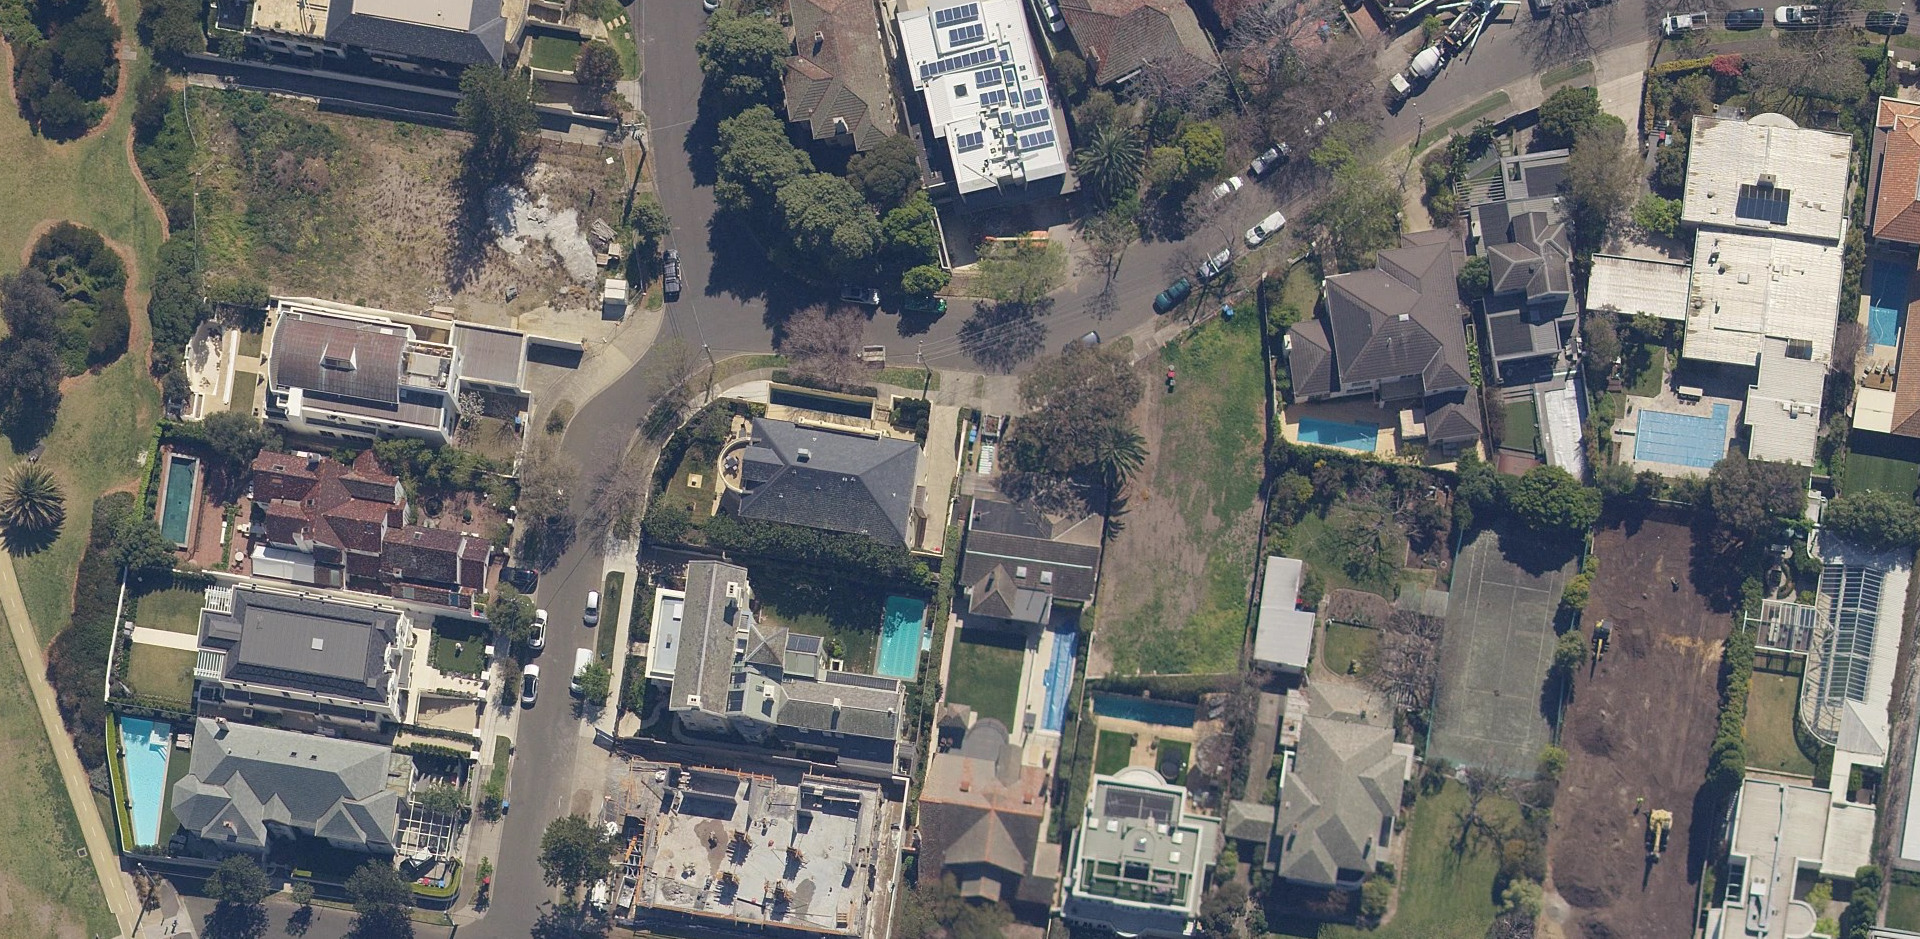

In [7]:
Image(filename = test_img_path, 
      width = config['width'], 
      height = config['height'])

# Import image, create mask

In [8]:
# Read in image
image = cv2.imread(test_img_path)

# Convert Image to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Create mask in HSV
mask = cv2.inRange(hsv, 
                   (config['hue-lower'], config['sat-lower'], config['value-lower']), 
                   (config['hue-upper'], config['sat-upper'], config['value-upper']))

# Slice the BLUE
imask = mask>0
pool_blue = numpy.zeros_like(image, 
                             numpy.uint8)
pool_blue[imask] = image[imask]

_, contours, _ = cv2.findContours(mask, 
                                  cv2.RETR_TREE, 
                                  cv2.CHAIN_APPROX_SIMPLE)

# Process contours
- Calculating area of each contour found
- Discard contour if not met by area condition in config dictionary
- Remove duplicates by condition in config dictionary (True/False)

In [9]:
# Find the contours within the area threshhold defined in config, and add to found_these
found_these = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    area = w * h
    if area >= config['area-threshhold']:
        found_these.append((x, y, w, h))

# Calculate Box Limits
box_limits = list(map(calc_box_limit, found_these))
    
if config['remove-dupes'] is True:

    # Find indices of duplicate boxes (boxes within boxes)
    discard = return_duplicate_indices(box_limits)

    # Calculate final contours
    final_contours = [item for index, item in enumerate(found_these) if index not in discard]
else:
    discard=[]
    final_contours=found_these

# Paint boxes onto image
for c in final_contours:
    x, y, w, h = c[0], c[1], c[2], c[3]
    cv2.rectangle(pool_blue,
                  (x,y),
                  (x + w, y + h),
                  (0, 255, 0),2)

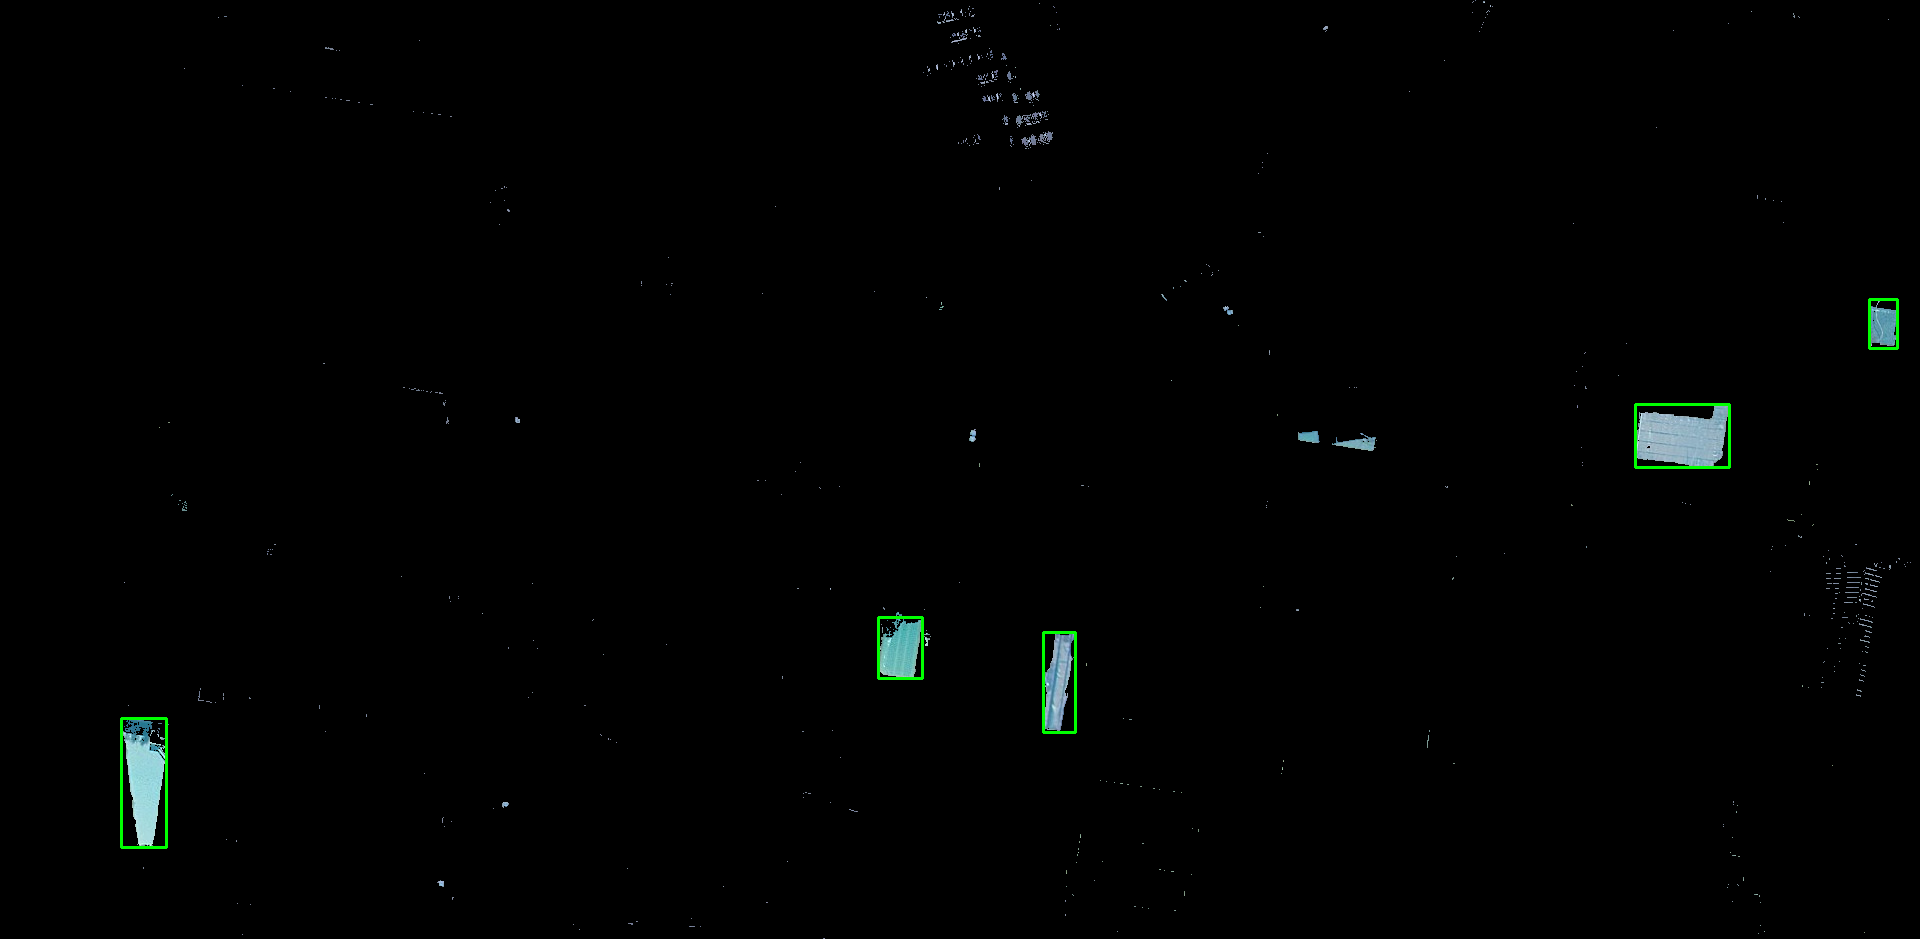

In [10]:
# Save result 
cv2.imwrite('test_result.png', 
            pool_blue)

# Show 
Image(filename = './test_result.png', 
      width = config['width'], 
      height = config['height'])

# Verify Values

In [11]:
found_these

[(121, 718, 45, 129),
 (1043, 632, 32, 100),
 (878, 617, 44, 61),
 (1635, 404, 94, 63),
 (1869, 299, 28, 49)]

In [12]:
box_limits

[(99, 143, 654, 782),
 (1027, 1059, 582, 682),
 (856, 900, 587, 647),
 (1588, 1682, 373, 435),
 (1855, 1883, 275, 323)]

In [13]:
discard

[]

In [14]:
final_contours

[(121, 718, 45, 129),
 (1043, 632, 32, 100),
 (878, 617, 44, 61),
 (1635, 404, 94, 63),
 (1869, 299, 28, 49)]

# Geocode using relative positions on image

In [43]:
# Helper function to calculate longitude and latitude from image
def find_long_lat_from_filepath(image_path):
    
    filename = image_path.split('/')[-1]
    split = filename.split('_')
    bottom_left_corner = [float(split[4] + '.' + split[5]), float(split[6] + '.' + split[7])]
    top_right_corner = [float(split[8] + '.' + split[9]), float(split[10] + '.' + split[11])]
    
    return bottom_left_corner, top_right_corner

In [46]:
bottom_left, top_right = find_long_lat_from_filepath(test_img_path)

In [47]:
long_diff = top_right[0] - bottom_left[0]
lat_diff = top_right[1] - bottom_left[1]
print(long_diff, lat_diff)

0.0025800000000231194 0.0009900000000016007


In [48]:
image_width = 1920 
image_height = 939
coords_of_pools = [((contour[0]/image_width * long_diff) + bottom_left[0],
                   top_right[1] - (contour[1]/image_height * lat_diff)) 
                   for contour in final_contours]

In [49]:
coords_of_pools

[(144.98633259374998, -37.895026996805115),
 (144.98757153125, -37.8949363258786),
 (144.98734981249999, -37.89492051118211),
 (144.98836703125, -37.894695942492014),
 (144.98868146875, -37.89458523961661)]